# Coursera - Advanced Machine Learning: Course 2
# Final Project

In [ ]:
## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import gc
import os
import re
import pickle
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm_notebook

from itertools import product


In [2]:
## define helper functions

In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [4]:
# define folder path
folder_path = {'local':'./', 'cousera': './'}

### Load data and concatenate train and test sets


In [5]:
DATA_FOLDER = folder_path['local']

train    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
test['date_block_num'] = 34
test['item_cnt_day'] =  0
cols = ['date_block_num','shop_id','item_id','item_cnt_day']
sales = pd.concat([train[cols],test[cols]])


# Part I - Data preprocessing and Feature extraction
###  We are given daily sales data  for each shop and each item carried by the store. 
### Our task is to predict monthly sales for each shop item combination.
### So we first aggredate data to get a feature matrix and then for each month satrting with the thirteenth 
### we append data for the previous twelve months

In [6]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({
    'item_cnt_day':{'target':'sum',
                    'target_mean':'mean', 'target_med':'median', 'target_max':'max',
                   'target_min':'min'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'target_shop':'sum'}})
                    #'target_shop_mean':'mean', 'target_shop_median':'median',
                    #'target_shop_max':'max', 'target_shop_min':'min'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'target_item':'sum',
                    'target_item_mean':'mean', 'target_item_median':'median',
                    'target_item_max':'max', 'target_item_min':'min'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [7]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

max_shift = 12
shift_range = list(range(1, max_shift+1))
print(shift_range)


for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= max_shift] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Widget Javascript not detected.  It may not be installed or enabled properly.


## Exploratory Data Analysis (EDA)
### Here we plot the time series data for select shop-item combination

In [8]:
r = re.compile("target_lag*")
lag_cols =list(filter(r.match,all_data.columns))
lag_cols

['target_lag_1',
 'target_lag_2',
 'target_lag_3',
 'target_lag_4',
 'target_lag_5',
 'target_lag_6',
 'target_lag_7',
 'target_lag_8',
 'target_lag_9',
 'target_lag_10',
 'target_lag_11',
 'target_lag_12']

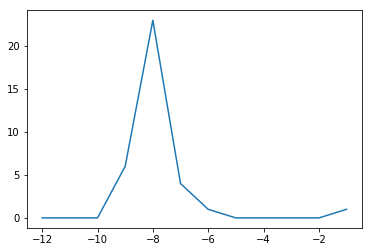

In [9]:
shop_id = 28
shop_data = all_data.loc[all_data['shop_id'] == shop_id, lag_cols].values
plt.plot(range(-len(lag_cols), 0), shop_data[np.random.randint(shop_data.shape[0])][: :-1])

## Training
### In order to expedite experimentation  we will restrict training to shops 26, 27, and 28
### We use two types of models:
- **LightGBM**
- **Random Forest**

In [10]:
mini_data = all_data[all_data['shop_id'].isin([26,27,28])]
mini_data['shop_id'].unique()

array([28, 27, 26])

In [11]:
## The following cols will be droped during training
## There are more 17,000 unique item_ids. So we will drop this when training our models
len(mini_data['item_id'].unique())
to_drop_cols.append('item_id')
to_drop_cols

['target_item_min_lag_10',
 'target_max',
 'target_max_lag_10',
 'target_shop_lag_10',
 'target_mean_lag_10',
 'target_med_lag_10',
 'target_item_mean',
 'target_item_max',
 'target_item_max_lag_10',
 'target_item',
 'target',
 'target_item_mean_lag_10',
 'target_item_min',
 'target_mean',
 'target_min',
 'target_item_median_lag_10',
 'target_shop',
 'target_min_lag_10',
 'target_med',
 'target_item_lag_10',
 'target_item_median',
 'target_lag_10',
 'date_block_num',
 'item_id']

### Train test split 
- Train set will consist of months 12 -32
- Validation set: mnoth 33
- Test set: month 34

In [12]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = mini_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 34


In [13]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = mini_data.loc[dates <  last_block-1].drop(to_drop_cols, axis=1)
X_val = mini_data.loc[dates ==  last_block-1].drop(to_drop_cols, axis=1)

y_train = mini_data.loc[dates <  last_block-1, 'target'].values
y_val =  mini_data.loc[dates == last_block-1, 'target'].values

## clip target values to [0, 20]
y_train =np.clip(y_train, 0, 20)
y_val =  np.clip(y_val, 0,20)

### Variable importance 
### We use  a random forest model to obtain variable importances

In [14]:
# Random Forest model
rf = RandomForestRegressor(max_depth=5)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_val)
pred_rf = np.clip(pred_rf, 0, 20)

In [15]:
print('Test RMSE for RF is %f' % np.sqrt(mean_squared_error(y_val, pred_rf)))

Test RMSE for RF is 1.071116


In [16]:
importances = sorted(zip(list(map(lambda x: round(x,4), 
                                  rf.feature_importances_)),list(X_train)), reverse=True)[:20]
importances

[(0.76329999999999998, 'target_lag_1'),
 (0.13880000000000001, 'target_item_lag_1'),
 (0.016199999999999999, 'item_category_id'),
 (0.015299999999999999, 'shop_id'),
 (0.011299999999999999, 'target_shop_lag_1'),
 (0.0080000000000000002, 'target_lag_5'),
 (0.0058999999999999999, 'target_lag_3'),
 (0.0044999999999999997, 'target_item_lag_3'),
 (0.0044000000000000003, 'target_shop_lag_6'),
 (0.0030999999999999999, 'target_item_mean_lag_1'),
 (0.0025000000000000001, 'target_lag_4'),
 (0.0020999999999999999, 'target_med_lag_1'),
 (0.0020999999999999999, 'target_item_mean_lag_3'),
 (0.002, 'target_shop_lag_4'),
 (0.002, 'target_lag_2'),
 (0.0018, 'target_shop_lag_12'),
 (0.0015, 'target_shop_lag_3'),
 (0.0014, 'target_item_min_lag_2'),
 (0.0012999999999999999, 'target_item_lag_4'),
 (0.0011000000000000001, 'target_max_lag_1')]

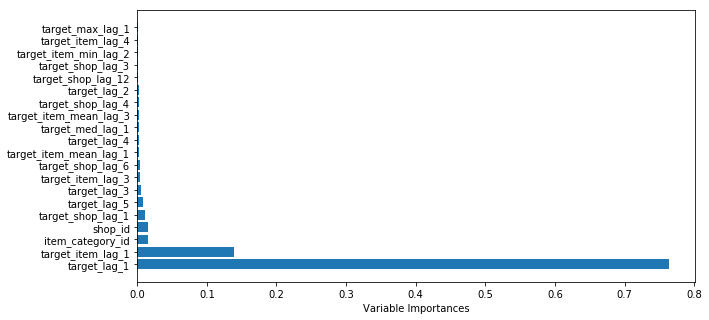

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
ax.barh(range(len(importances)), [x[0] for x in importances], align='center')
ax.set_yticks(range(len(importances)))
ax.set_yticklabels([x[1] for x in importances])
ax.set_xlabel('Variable Importances')
plt.show()

### The table above shows that the most important lag times are 1-5 and 12. So in our final training we will retain only these ones

## Parameter Tuning

In [ ]:
errors = []
min_depth = [3, 5,10]
n_estimators = [10, 15]
for d in min_depth:
    for num in n_estimators:
        print('Training with depth {} and estimators {}'.format(d, num))
        rf = RandomForestRegressor(max_depth=d, n_estimators=num)
        rf.fit(X_train, y_train)
        pred_rf = rf.predict(X_val)
        pred_rf = np.clip(pred_rf, 0, 20)
        rmse = np.sqrt(mean_squared_error(y_val, pred_rf))
        errors.append({'depth':d, 'n_estimators': num, 'rmse':rmse})

In [ ]:
print(errors)
best_ind = np.argmin([d['rmse'] for d in errors])
best_params = errors[best_ind]
print('Best parameters: ', errors[best_ind])

# Part II
## We train a LightGBM model and a Random Forest model using best parameters found above. As seen from variable importances we also limit lag times to 1,2,3,4,5, and 12.

In [18]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({
    'item_cnt_day':{'target':'sum',
                    'target_mean':'mean', 'target_med':'median', 'target_max':'max',
                   'target_min':'min'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'target_shop':'sum'}})
                    #'target_shop_mean':'mean', 'target_shop_median':'median',
                    #'target_shop_max':'max', 'target_shop_min':'min'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg(
    {'item_cnt_day':{'target_item':'sum',
                    'target_item_mean':'mean', 'target_item_median':'median',
                    'target_item_max':'max', 'target_item_min':'min'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [19]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

max_shift = 12
shift_range = [1,2,3,4,5,12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= max_shift] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

Widget Javascript not detected.  It may not be installed or enabled properly.


In [20]:
to_drop_cols.append('item_id')
to_drop_cols

['target_item',
 'target_max',
 'target',
 'target_med',
 'target_item_min',
 'target_item_mean',
 'target_shop',
 'target_mean',
 'target_item_max',
 'target_min',
 'target_item_median',
 'date_block_num',
 'item_id']

In [21]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 34


In [22]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block-1].drop(to_drop_cols, axis=1)

X_val = all_data.loc[dates ==  last_block-1].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block-1, 'target'].values
y_val =  all_data.loc[dates == last_block-1, 'target'].values

## clip target values to [0, 20]
y_train =np.clip(y_train, 0, 20)
y_val =  np.clip(y_val, 0,20)

In [23]:
## Train Models

# GBM model
#print('Training LightGBM model')
#model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
#pred_val_lgb = model.predict(X_val)
#pred_val_lgb = np.clip(pred_val_lgb, 0, 20)

# Random Forest model
#print('Training Random Forest model')
#rf.fit(X_train, y_train)
#pred_val_rf = rf.predict(X_val)
#pred_val_rf = np.clip(pred_val_rf, 0, 20)

# Linear Regression
#print('Training linear regression model')
#lr = LinearRegression()
#lr.fit(X_train.values, y_train)
#pred_val_lr = lr.predict(X_val)
#pred_val_lr = np.clip(pred_val_lr, 0, 20)

In [24]:
#val_data = pd.DataFrame({'pred_lgb':pred_val_lgb, 'pred_rf':pred_val_rf,'pred_lr':pred_val_lr,  'y_val': y_val})
#val_data.to_csv('./val_data', index=False)

### We load previously calculated predictions for the validation set

In [25]:
# load validation data
val_data = pd.read_csv('./val_data')

In [26]:
val_data.head()

,pred_lgb,pred_lr,pred_rf,y_val
0,0.055752,0.125921,0.029788,1.0
1,0.801977,0.225960,0.762917,1.0
2,0.555554,0.467386,0.508839,2.0
3,0.126933,0.132144,0.106141,1.0
4,0.614055,0.945223,0.838084,1.0


In [27]:
pred_val_lgb = val_data['pred_lgb']
pred_val_rf = val_data['pred_rf']
pred_val_lr = val_data['pred_lr']
y_val = val_data['y_val']

In [28]:
print('Validation RMSE for LightGBM is %f' % np.sqrt(mean_squared_error(y_val, pred_val_lgb)))
print('Validation RMSE for RF is %f' % np.sqrt(mean_squared_error(y_val, pred_val_rf)))
print('Validation RMSE for lr is %f' % np.sqrt(mean_squared_error(y_val, pred_val_lr)))

Validation RMSE for LightGBM is 0.918010
Validation RMSE for RF is 0.962971
Validation RMSE for lr is 1.024326


## Ensembling: Simplex method
### We find the best choice of parameters a1, a2, a3 that gives the best rmse

In [29]:
num_iter=10000
err_mat = np.zeros((num_iter, 4))
for i in range(num_iter):
    a1,a2 = np.random.uniform(0,1,size=2)
    a3=1-a1-a2
    preds = a1*pred_val_lgb + a2*pred_val_rf + a3*pred_val_lr
    score = np.sqrt(mean_squared_error(y_val, preds))
    err_mat[i] = [a1,a2,a3,score]

df=pd.DataFrame(err_mat)
df.columns=['a1','a2','a3','rmse']    

In [30]:
df.head()
df['rmse'].min()

0.9177980497989251

In [31]:
alpha = df.loc[df['rmse'].idxmin()][:3].values
alpha

array([ 0.95254237,  0.00189372,  0.0455639 ])

# Part II: Submission

In [32]:
# Now retrain on entire train set
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)
X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
y_train = all_data.loc[dates <  last_block, 'target'].values
## clip target values to [0, 20]
y_train =np.clip(y_train, 0, 20)

X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

Test `date_block_num` is 34


In [33]:
# GBM model
#print('Training LightGBM model')
#model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

# Random Forest model
#print('Training Random Forest model')
#rf.fit(X_train, y_train)

# Linear Regression
#print('Training linear regression model')
#lr = LinearRegression()
#lr.fit(X_train.values, y_train)


In [34]:
# Serialize models
#pickle.dump(model, open('model_lgb.pkl', 'wb'))
#pickle.dump(rf, open('model_rf.pkl', 'wb'))
#pickle.dump(lr, open('model_lr.pkl', 'wb'))

### We load pre-trained models and predict on the test set for submission

In [35]:
## load pickled models
model_lgb = pickle.load(open('model_lgb.pkl','rb'))
model_rf = pickle.load(open('model_rf.pkl','rb'))
model_lr = pickle.load(open('model_lr.pkl','rb'))

In [36]:
pred_test_lgb = model_lgb.predict(X_test)
pred_test_lgb = np.clip(pred_test_lgb, 0, 20)

pred_test_rf = model_rf.predict(X_test)
pred_test_rf = np.clip(pred_test_rf, 0, 20)

pred_test_lr = model_lr.predict(X_test)
pred_test_lr = np.clip(pred_test_lr, 0, 20)

In [37]:
# Serialize models
#pickle.dump(model, open('model_lgb.pkl', 'wb'))
#pickle.dump(rf, open('model_rf.pkl', 'wb'))
#pickle.dump(lr, open('model_lr.pkl', 'wb'))

In [38]:
pred_simplex = alpha[0]*pred_test_lgb + alpha[1]*pred_test_rf + alpha[2]*pred_test_lr

In [39]:
## prepare submission file
submit_file = pd.read_csv('./sample_submission.csv.gz')
submit_file.loc[ :, 'item_cnt_month']= pred_simplex

In [40]:
submit_file.head()

,ID,item_cnt_month
0,0,0.401979
1,1,0.224210
2,2,0.768202
3,3,0.291382
4,4,3.683797


In [41]:
# save file
submit_file.to_csv('./lgb_rf_lr_simplex_020118.csv', index=False)